In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pandas.plotting import autocorrelation_plot
from IPython import display
import duckdb

In [2]:
import datetime as dt
from pandas.tseries.offsets import Day
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
from sklearn.metrics import mean_squared_error, r2_score
from Utils import *

# SPX implied volatility data

In [3]:
spx_vol = pd.read_csv('processed_data/test.csv')

In [89]:
spx_vol.rename({'Unnamed: 0': 'Date', 'Unnamed: 1': 'delta'}, axis=1, inplace=True)

In [90]:
spx_vol.head(10)

,Date,delta,10,30,60,91,122,152,182,273,365,547,730
0,2020-01-02,-90,0.000494,0.000381,0.000469,0.000476,0.000477,0.000485,0.000490,0.000495,0.000502,0.000513,0.000527
1,2020-01-02,-85,0.000431,0.000379,0.000457,0.000473,0.000478,0.000488,0.000494,0.000507,0.000517,0.000534,0.000549
2,2020-01-02,-80,0.000391,0.000384,0.000456,0.000477,0.000487,0.000497,0.000505,0.000522,0.000533,0.000557,0.000577
3,2020-01-02,-75,0.000379,0.000393,0.000463,0.000488,0.000501,0.000512,0.000519,0.000540,0.000553,0.000580,0.000606
4,2020-01-02,-70,0.000381,0.000405,0.000476,0.000503,0.000519,0.000530,0.000537,0.000562,0.000576,0.000604,0.000632
5,2020-01-02,-65,0.000386,0.000419,0.000492,0.000522,0.000539,0.000549,0.000557,0.000587,0.000602,0.000629,0.000657
6,2020-01-02,-60,0.000394,0.000436,0.000510,0.000543,0.000560,0.000571,0.000579,0.000615,0.000631,0.000657,0.000683
7,2020-01-02,-55,0.000404,0.000454,0.000532,0.000566,0.000584,0.000595,0.000604,0.000646,0.000663,0.000687,0.000711
8,2020-01-02,-50,0.000416,0.000475,0.000556,0.000593,0.000612,0.000623,0.000633,0.000679,0.000697,0.000720,0.000741
9,2020-01-02,-45,0.000430,0.000498,0.000583,0.000622,0.000643,0.000655,0.000666,0.000716,0.000734,0.000756,0.000775


In [ ]:
spx_vol_avg = spx_vol.groupby()

# SPX price data

In [5]:
spx = pd.read_csv('data/SPX.csv', skiprows=2)

In [6]:
spx.shape

(9159, 6)

In [16]:
spx['Date'] = pd.to_datetime(spx['Date'], format='%m/%d/%Y')

In [58]:
spx["Year"] = spx['Date'].dt.to_period('Y')

In [43]:
spx["Return"] = convert_to_daily_returns(spx.Close)*100

In [45]:
spx["Return_lag1"] = spx["Return"].shift(1)

In [59]:
spx.head(10)

,Date,Ticker,Open,High,Low,Close,Return,Return_lag1,Year
0,1986-01-02,_SPXD,211.24,211.28,208.93,209.59,NaN,NaN,1986
1,1986-01-03,_SPXD,209.60,210.88,209.51,210.88,0.615487,NaN,1986
2,1986-01-06,_SPXD,210.89,210.98,209.93,210.65,-0.109067,0.615487,1986
3,1986-01-07,_SPXD,210.69,213.80,210.65,213.80,1.495371,-0.109067,1986
4,1986-01-08,_SPXD,213.79,214.57,207.49,207.97,-2.726848,1.495371,1986
5,1986-01-09,_SPXD,207.96,207.97,204.51,206.11,-0.894360,-2.726848,1986
6,1986-01-10,_SPXD,206.17,207.33,205.52,205.96,-0.072777,-0.894360,1986
7,1986-01-13,_SPXD,205.97,206.83,205.52,206.72,0.369004,-0.072777,1986
8,1986-01-14,_SPXD,206.75,207.37,206.06,206.64,-0.038700,0.369004,1986
9,1986-01-15,_SPXD,206.64,208.27,206.64,208.26,0.783972,-0.038700,1986


In [65]:
year_counts = pd.DataFrame(spx.iloc[1:].groupby(['Year']).size())
year_counts.columns = ['Count']
year_counts.reset_index()
year_counts.head()

,Count
Year,
1986,252
1987,253
1988,253
1989,252
1990,253


In [66]:
# Use the counts to calculate the position of our xticks
year_idx = year_counts['Count'].cumsum().shift() - 1
year_idx[0] = 0
year_idx = year_idx.convert_dtypes()
year_idx.head()

Year
1986       0
1987     251
1988     504
1989     757
1990    1009
Freq: A-DEC, Name: Count, dtype: Int64

In [92]:
spx_ret = spx["Return"].iloc[1:]

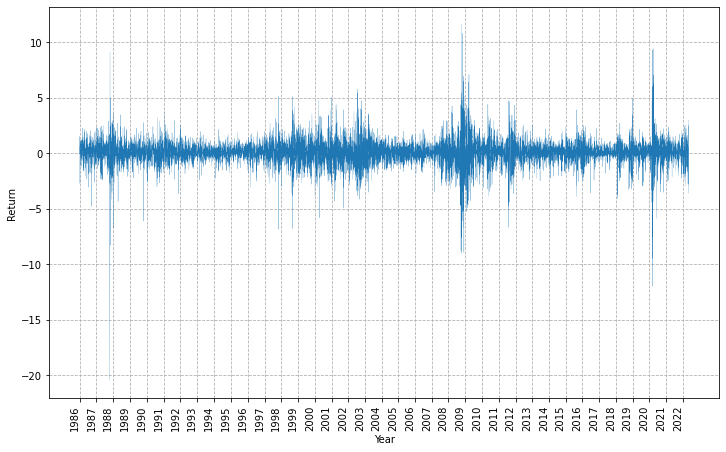

In [93]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 8))
ax.plot(spx_ret, linewidth=0.2)
fig.autofmt_xdate(rotation=90)
ax.set_xticks(year_idx)
ax.set_xticklabels(year_counts.index)
ax.set_xlabel('Year')
ax.set_ylabel('Return')
ax.grid(visible=True, which='major', linestyle='--')

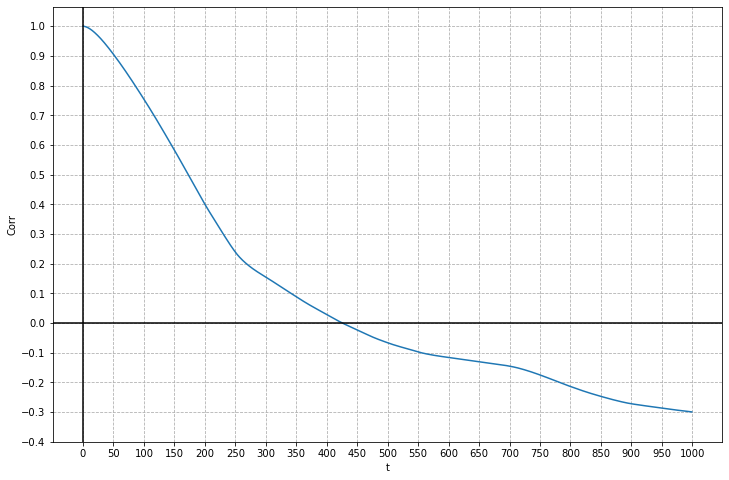

In [6]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 8))
plt.plot(np.arange(1000), [targets["Close"].autocorr(t) for t in range(1000)])
ax.axvline(0, color='black')
ax.axhline(0, color='black')
ax.set_xticks(range(0, 1001, 50))
ax.set_yticks(np.arange(-0.4, 1.05, 0.1))
ax.set_xlabel('t')
ax.set_ylabel('Corr')
ax.grid(visible=True, which='major', linestyle='--')

# Baseline: Autoregressive Model (Linear Regression)

### SPX Returns Estimation (index "SPX") & VIX Estimation (index "VIX")

In [65]:
targets_train = np.array(df["VIX"][(
    train_dates[0] <= df["Date"]) & (df["Date"] <= train_dates[-1] + Day())].reindex())
targets_test = np.array(df["VIX"][(
    test_dates[0] <= df["Date"]) & (df["Date"] <= test_dates[-1] + Day())].reindex())

In [56]:
targets_train = targets_train.flatten()
targets_test = targets_test.flatten()

In [66]:
targets = np.concatenate([targets_train, targets_test])

In [67]:
test_len = len(targets_test)
train_size = 365

In [68]:
lags = [1, 5, 10]
ar_preds = []
for lag in lags:
    history = [ret for ret in targets_train[-(train_size+lag):-lag]]
    pred_target = targets_train[-lag]
    predictions = []
    for t in range(test_len):
#         model_ar = ARIMA(history, order=(lag,0,0), enforce_stationarity=False)
#         predictions.append(model_ar_fit.forecast(steps=1, alpha=0.05)[0])
        model_ar = sm.regression.linear_model.OLS(
            endog=history[lag:], exog=history[:-lag]).fit()
        predictions.append(model_ar.predict(pred_target)[0])
        history.append(pred_target)
        pred_target = targets[-(test_len+lag)+t]
    predictions = np.array(predictions)
    ar_preds.append(predictions)
    print(f'Lag-{lag} MSE: {mean_squared_error(targets_test, predictions)}')

Lag-1 MSE: 9.066804025182746
Lag-5 MSE: 27.439926348066713
Lag-10 MSE: 50.04074032803967


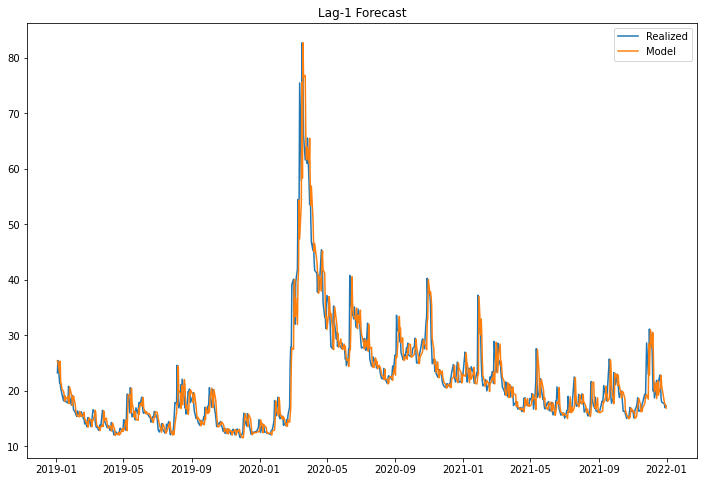

In [70]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 8))
ax.set_title(f"Lag-{lags[0]} Forecast")
plt.plot(test_dates[1:], targets_test, label='Realized')
plt.plot(test_dates[1:], ar_preds[0], label='Model')
_ = plt.legend()

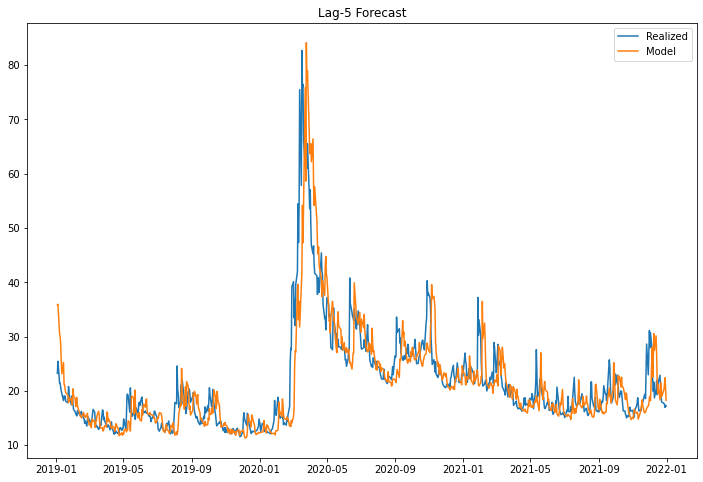

In [71]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 8))
ax.set_title(f"Lag-{lags[1]} Forecast")
plt.plot(test_dates[1:], targets_test, label='Realized')
plt.plot(test_dates[1:], ar_preds[1], label='Model')
_ = plt.legend()

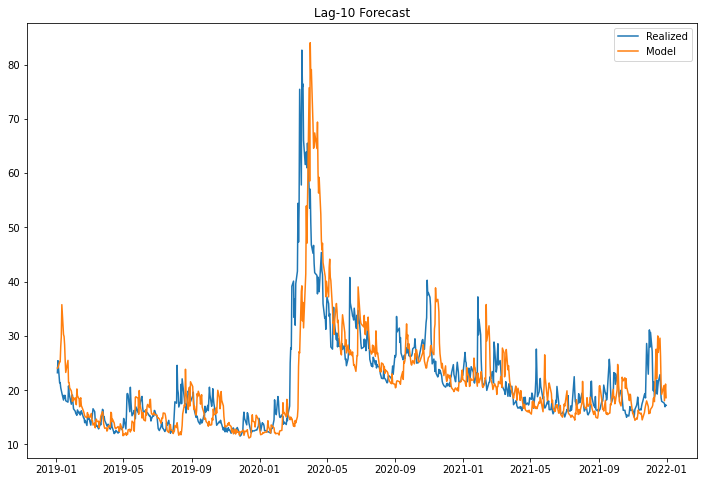

In [72]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 8))
ax.set_title(f"Lag-{lags[2]} Forecast")
plt.plot(test_dates[1:], targets_test, label='Realized')
plt.plot(test_dates[1:], ar_preds[2], label='Model')
_ = plt.legend()

In [73]:
print("-------------MSE-------------")
for i, lag in enumerate(lags):
    print(f'Lag-{lag} MSE: {mean_squared_error(targets_test, ar_preds[i])}')

print("-------------MAE-------------")
for i, lag in enumerate(lags):
    print(f'Lag-{lag} MAE: {np.mean(np.abs(targets_test - ar_preds[i]))}')

print("-------------R2--------------")
for i, lag in enumerate(lags):
    print(f'Lag-{lag} R2: {r2_score(targets_test, ar_preds[i])}')

print("-----------AE STD------------")
for i, lag in enumerate(lags):
    print(f'Lag-{lag} AE std: {np.std(np.abs(targets_test - ar_preds[i]))}')

-------------MSE-------------
Lag-1 MSE: 9.066804025182746
Lag-5 MSE: 27.439926348066713
Lag-10 MSE: 50.04074032803967
-------------MAE-------------
Lag-1 MAE: 1.8272903754764187
Lag-5 MAE: 3.0791680911285413
Lag-10 MAE: 4.052057521268215
-------------R2--------------
Lag-1 R2: 0.896654061570096
Lag-5 R2: 0.6872321348280993
Lag-10 R2: 0.4296218100044168
-----------AE STD------------
Lag-1 AE std: 2.393285170821479
Lag-5 AE std: 4.23776476631756
Lag-10 AE std: 5.798411004091842


# Baseline: GARCH

In [5]:
SPX = pd.read_csv('data/SPX.csv', skiprows=2)
VIX = pd.read_csv('data/VIX.csv', skiprows=2)
SPX.drop(columns=["Ticker", "Open", "High", "Low"], inplace=True)
VIX.drop(columns=["Ticker", "Open", "High", "Low"], inplace=True)
df = SPX.merge(VIX, on="Date")
df.columns = ["Date", "SPX", "VIX"]
df["Return"] = df.SPX.pct_change(periods=1)*100

In [6]:
df["Date"] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df["Year"] = df['Date'].dt.to_period('Y')

In [7]:
df = df[(train_dates[0] <= df["Date"]) & (df["Date"] <= test_dates[-1] + Day())].reindex()
df

,Date,SPX,VIX,Return,Year
2792,1997-01-17,776.17,20.87,0.834037,1997
2793,1997-01-20,776.70,20.25,0.068284,1997
2794,1997-01-21,782.72,19.51,0.775074,1997
2795,1997-01-22,786.23,18.55,0.448436,1997
2796,1997-01-23,777.56,20.77,-1.102731,1997
...,...,...,...,...,...
9064,2021-12-27,4791.19,17.68,1.383896,2021
9065,2021-12-28,4786.35,17.54,-0.101019,2021
9066,2021-12-29,4793.06,16.95,0.140190,2021
9067,2021-12-30,4778.73,17.33,-0.298974,2021


In [8]:
vix_test = np.array(df["VIX"][(
    test_dates[0] <= df["Date"]) & (df["Date"] <= test_dates[-1] + Day())].reindex())

In [9]:
df_len = len(df)
test_len = len(vix_test)
train_size = 365

In [10]:
garch_model = arch_model(
    y=np.array(df["Return"]),
    p=1, q=1, mean='Zero', 
    dist='studentst')

In [11]:
lags = [1, 5, 10]

In [12]:
garch_preds = []
for i, lag in enumerate(lags):
    predictions = []
    for t in range(test_len):
        garch_fit = garch_model.fit(
            first_obs=df_len-(test_len+train_size+lag)+t, 
            last_obs=df_len-(test_len+lag)+t, disp='off') 
        predictions.append(
            np.array(garch_fit.forecast(horizon=1, reindex=False).variance).flatten()[0])
    garch_preds.append(np.sqrt(252*np.array(predictions)))

In [64]:
print("-------------MSE-------------")
for i, lag in enumerate(lags):
    print(f'Lag-{lag} MSE: {mean_squared_error(vix_test, garch_preds[i])}')

print("-------------MAE-------------")
for i, lag in enumerate(lags):
    print(f'Lag-{lag} MAE: {np.mean(np.abs(vix_test - garch_preds[i]))}')

print("-------------R2--------------")
for i, lag in enumerate(lags):
    print(f'Lag-{lag} R2: {r2_score(vix_test, garch_preds[i])}')
    
print("-----------AE STD------------")
for i, lag in enumerate(lags):
    print(f'Lag-{lag} AE std: {np.std(np.abs(vix_test - garch_preds[i]))}')

-------------MSE-------------
Lag-1 MSE: 80.64223439753674
Lag-5 MSE: 105.83193391914664
Lag-10 MSE: 138.57024414484985
-------------MAE-------------
Lag-1 MAE: 6.247782363166118
Lag-5 MAE: 6.814586566433901
Lag-10 MAE: 7.529830990496829
-------------R2--------------
Lag-1 R2: 0.08081752205626336
Lag-5 R2: -0.2063016357635845
Lag-10 R2: -0.5794619448964853
-----------AE STD------------
Lag-1 AE std: 6.450383704869592
Lag-5 AE std: 7.706707717808249
Lag-10 AE std: 9.048308648548822


In [23]:
test = pd.DataFrame(columns=['preds', 'targets'], index=range(len(vix_test)))
test['preds'] = garch_preds[1]
test['targets'] = vix_test
    
print('Corr: ')
print(test.corr().iloc[0,1])

Corr: 
0.7679521664135645


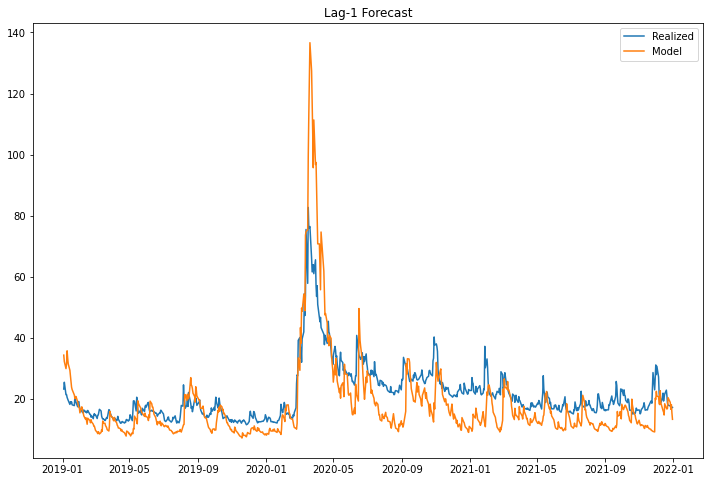

In [14]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 8))
ax.set_title(f"Lag-{lags[0]} Forecast")
plt.plot(test_dates[1:], vix_test, label='Realized')
plt.plot(test_dates[1:], garch_preds[0], label='Model')
_ = plt.legend()

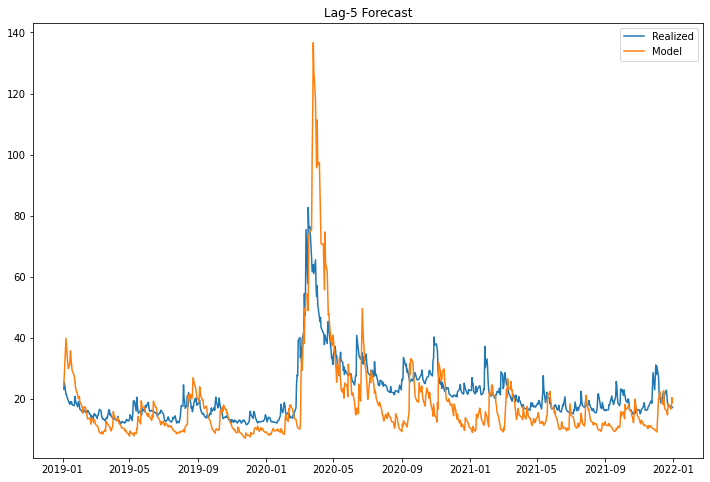

In [15]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 8))
ax.set_title(f"Lag-{lags[1]} Forecast")
plt.plot(test_dates[1:], vix_test, label='Realized')
plt.plot(test_dates[1:], garch_preds[1], label='Model')
_ = plt.legend()

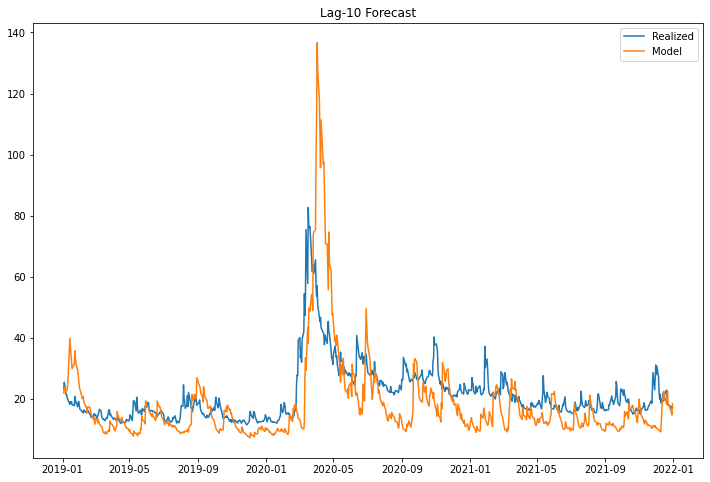

In [16]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 8))
ax.set_title(f"Lag-{lags[2]} Forecast")
plt.plot(test_dates[1:], vix_test, label='Realized')
plt.plot(test_dates[1:], garch_preds[2], label='Model')
_ = plt.legend()